# Jacopo D'Abramo
# jacopo.dabramo@studio.unibo.it

# 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from functools import partial
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d
from sklearn.model_selection import ParameterGrid

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tracce/exam_superv.csv')
df.shape

(1200, 4)

In [ ]:
df.describe()

,0,1,y,2
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,2.391668,1.996186,0.507500,2.494236
std,0.804770,0.507227,0.500152,0.589235
min,0.343023,0.509424,0.000000,1.500260
25%,1.806657,1.809635,0.000000,1.974389
50%,2.744439,1.983524,1.000000,2.469778
75%,3.092275,2.201484,1.000000,2.995198
max,3.529782,3.647299,1.000000,3.498523


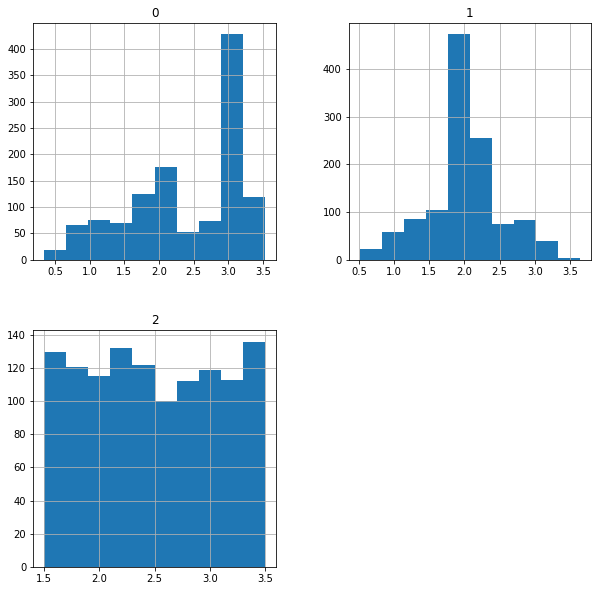

In [ ]:
pd.DataFrame.hist(df.drop(['y'],axis=1)
                  , figsize = [10,10]
                 );

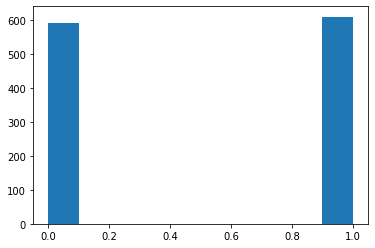

In [ ]:
plt.hist(df['y'])
plt.show()

# 1

In [ ]:
X = df.drop(['y'],axis = 1)
y = df['y']

In [ ]:
kbest = SelectKBest(score_func=partial(mutual_info_classif), k=X.shape[1]-1)
fit = kbest.fit(X,y)
X_red = fit.transform(X)
display(pd.DataFrame(X_red))

,0,1
0,1.589942,2.977770
1,2.908437,1.837522
2,3.284091,1.818476
3,3.148717,2.071991
4,2.116881,2.133874
...,...,...
1195,3.044919,2.043135
1196,2.911515,2.193380
1197,1.702582,0.553983
1198,2.695799,1.317995


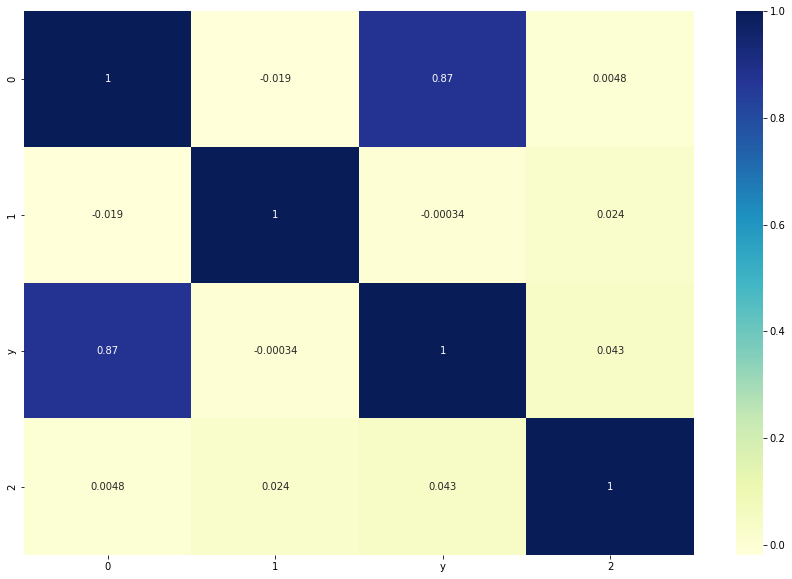

In [ ]:
corr = df[df.columns].corr()
plt.figure(figsize=(15,10)) # set X and Y size
sns.heatmap(corr, cmap="YlGnBu", annot=True);

In [ ]:
focus = [0,1]
X_new = np.array(X)
X_new = X_new[:,focus]
display(pd.DataFrame(X_new))

,0,1
0,1.589942,2.977770
1,2.908437,1.837522
2,3.284091,1.818476
3,3.148717,2.071991
4,2.116881,2.133874
...,...,...
1195,3.044919,2.043135
1196,2.911515,2.193380
1197,1.702582,0.553983
1198,2.695799,1.317995


# Trying to clust with DBSCAN

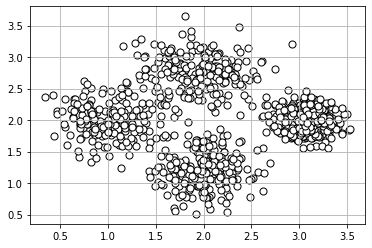

In [ ]:
plt.scatter(X_new[:,0], X_new[:,1]
            , c='white'          # color filling the data markers
            , edgecolors='black' # edge color for data markers
            , marker='o'         # data marker shape, e.g. triangles (v<>^), square (s), star (*), ...
            , s=50)              # data marker size
plt.grid()  # plots a grid on the data
plt.show()

In [ ]:
model = DBSCAN()
pred = model.fit_predict(X_new)
print(np.unique(pred))

[0]


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_clusters(X, y, dim, points,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.tab10, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(10) # by default the last of the map (to be improved)
                 ):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(X[y==labels[i],dim[0]], 
                    X[y==labels[i],dim[1]], 
                    s=10, 
                    c = [color], # scatter requires a sequence of colors
                    marker='s', 
                    label=labels_prefix+str(labels[i]))
    plt.scatter(points[:,dim[0]], 
                points[:,dim[1]], 
                s=50, 
                marker='*', 
                c=[points_color], 
                label=points_name)
    plt.legend()
    plt.grid()
    plt.show()   

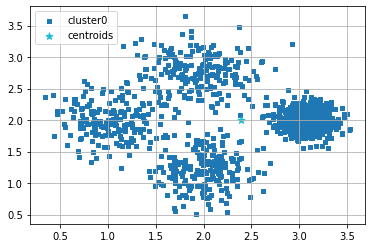

In [ ]:
labelsAll = np.unique(pred)
clusterLabel = labelsAll[labelsAll != -1]
cluster_centers = np.empty((len(clusterLabel),X_new.shape[1]))
for i in clusterLabel:
    cluster_centers[i,:] = np.mean(X_new[pred==i,:], axis = 0)
plot_clusters(X_new,pred,dim=(focus[0],focus[1]), points = cluster_centers)

In [ ]:
param_grid = {'eps': list(np.arange(0.01, 1, 0.01)), 'min_samples': list(range(1,10,1))}
params = list(ParameterGrid(param_grid))

In [ ]:
dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])
for i in range(len(params)):
    db = DBSCAN(**(params[i]))
    y_db = db.fit_predict(X_new)

    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    
    if n_clusters > 1:
        X_cl = X_new[y_db!=-1,:]
        y_db_cl = y_db[y_db!=-1]
        silhouette = silhouette_score(X_cl,y_db_cl)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
        dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]
#%%
sil_thr = 0.56  # visualize results only for combinations with silhouette above the threshold
unc_thr = 10 # visualize results only for combinations with unclustered% below the threshold
dbscan_out[(dbscan_out['silhouette']>=sil_thr)\
         & (dbscan_out['unclust%']<=unc_thr)\
         & (dbscan_out['n_clusters']<=4)]

,eps,min_samples,n_clusters,silhouette,unclust%
103,0.13,4.0,3.0,0.632073,4.166667
104,0.13,5.0,3.0,0.636066,5.166667
121,0.15,4.0,2.0,0.571673,2.666667
124,0.15,7.0,3.0,0.634548,5.000000
125,0.15,8.0,3.0,0.641790,6.416667
126,0.15,9.0,4.0,0.706531,6.833333
130,0.16,4.0,2.0,0.566636,1.750000
131,0.16,5.0,2.0,0.569389,2.250000
132,0.16,6.0,3.0,0.624964,2.833333
133,0.16,7.0,3.0,0.629870,3.833333


I choose eps = 0.18 and minsamples = 4

In [ ]:
db = DBSCAN(eps = 0.18, min_samples = 4)
pred = db.fit_predict(X_new)
cluster_labels_all = np.unique(pred)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)
print("there are {} clusters".format(n_clusters))
print("The cluster labels are {}".format(cluster_labels))


there are 2 clusters
The cluster labels are [0 1]


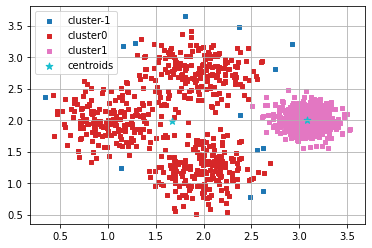

In [ ]:
cluster_centers = np.empty((n_clusters,X_new.shape[1]))
for i in cluster_labels:
    cluster_centers[i,:] = np.mean(X_new[pred==i,:], axis = 0)
plot_clusters(X_new,pred,dim=(focus[0],focus[1]), points = cluster_centers)


# 3

In [ ]:
from sklearn.metrics import pair_confusion_matrix
pcm = pair_confusion_matrix(y,pred)
pcm / pcm.sum()
print("The percentage of match between the two clustering schemes is {:6.2f}%"\
    .format((pcm / pcm.sum()).diagonal().sum()*100))

The percentage of match between the two clustering schemes is  98.46%


# 5

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tracce/exam_unsuperv.csv')
df.shape
display(df)

,0,1,2
0,3.185684,2.208597,3.045639
1,2.179220,1.410352,2.396246
2,2.242676,2.624663,2.833286
3,1.980176,0.836695,2.188114
4,3.210992,2.251962,3.309826
...,...,...,...
4795,2.863416,1.872470,2.709537
4796,0.377324,1.974179,1.754192
4797,3.276402,2.170215,3.430396
4798,1.995407,1.373787,2.809460


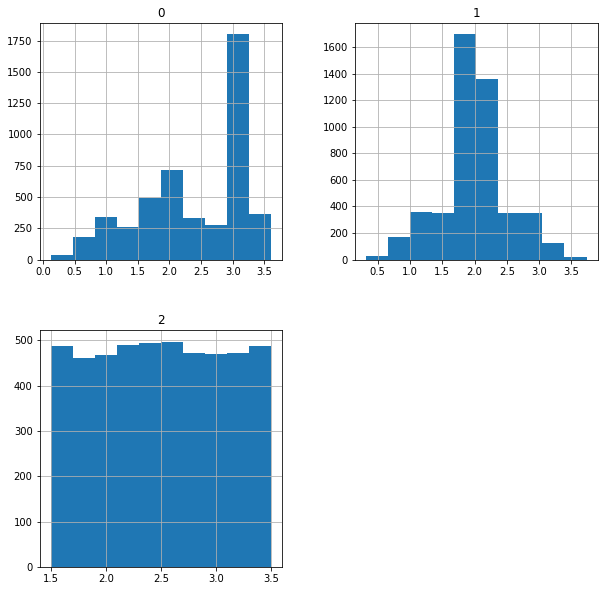

In [ ]:
pd.DataFrame.hist(df
                  , figsize = [10,10]
                 );

In [ ]:
focus = [0,1]
X_new_2 = np.array(df)
X_new_2 = X_new_2[:,focus]

In [ ]:
db = DBSCAN(eps = 0.18, min_samples = 4)
pred_2 = db.fit_predict(X_new_2)
cluster_labels_all = np.unique(pred_2)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)
print("there are {} clusters".format(n_clusters))
print("The cluster labels are {}".format(cluster_labels))

there are 1 clusters
The cluster labels are [0]


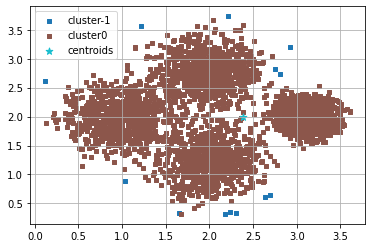

In [ ]:
cluster_centers = np.empty((n_clusters,X_new_2.shape[1]))
for i in cluster_labels:
    cluster_centers[i,:] = np.mean(X_new_2[pred_2==i,:], axis = 0)
plot_clusters(X_new_2,pred_2,dim=(focus[0],focus[1]), points = cluster_centers)
